# MNIST Training

This notebook reproduces training for all the models for MNIST Experiments, namely:  
> * [MNIST Training Using Only Digits](#only_MNIST_training)  
> * [MNIST Training Using Letters as Background Images](#BG)
> * [OpenSet Learning](#open)
>  * [Entropic OpenSet](#Entropic)
>  * [ObjectoSphere](#ObjectoSphere)
>  * [Entropic OpenSet & ObjectoSphere](#EntropicObjectoSphere)

The visualizations with a particular set of unknowns may be found in the respective notebooks  

In [1]:
import sys
sys.path.insert(0, '../Tools')
import model_tools
import visualizing_tools
import evaluation_tools
import data_prep

/home/adhamija/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Setup GPU to use

In [2]:
GPU_NO="0"
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = GPU_NO
#session = tf.Session(config=config)
set_session(tf.Session(config=config))

In [3]:
import keras
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from keras import backend as K
from keras.layers import Input

import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline

Loading the datasets

In [4]:
mnist=data_prep.mnist_data_prep()
letters=data_prep.letters_prep()
hindi=data_prep.hindi_letters()

In [16]:
alpha = 0

In [5]:
def alpha_softmax(x, axis=-1):
    exponential_values = K.exp(x)
    sum_of_exponential_values = K.sum(exponential_values, axis=axis, keepdims=True)
    extra_term=K.exp(K.ones(1)*alpha)
    return exponential_values / (extra_term+sum_of_exponential_values)

In [6]:
get_custom_objects().update({'alpha_softmax': Activation(alpha_softmax)})

In [7]:
results_dir='Alpha_Models/'
if not os.path.exists(results_dir+'Plots'):
    os.makedirs(results_dir+'Plots')
    os.makedirs(results_dir+'DIRs')

<a id='only_MNIST_training'></a>

### MNIST Training Using Only Digits

In [8]:
model_saver = ModelCheckpoint(results_dir+'Vanilla.h5py', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max', period=1)
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, verbose=1, mode='max')
callbacks_list = [earlystop,model_saver]
#callbacks_list = [model_saver]

In [9]:
vanilla_lenet_pp=model_tools.LeNet_plus_plus(activation_type=alpha_softmax)
#adam = Adam(lr=0.001)
adam = SGD(lr=0.01, decay=0.0009, momentum=0.8, nesterov=False)
#sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=False)
#sgd = SGD(lr=0.01, decay=0.00009, momentum=0.8, nesterov=False)
vanilla_lenet_pp.compile(optimizer=adam,loss={'softmax': 'categorical_crossentropy'},metrics=['accuracy'])
info=vanilla_lenet_pp.fit(x=mnist.X_train,y=mnist.Y_train,validation_data=[mnist.X_val,mnist.Y_val], batch_size=256, epochs=25,verbose=1, callbacks=callbacks_list)

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 12s 247us/step - loss: 0.9146 - acc: 0.6753 - val_loss: 0.6194 - val_acc: 0.8025
Epoch 2/25
48000/48000 [==============================] - 9s 196us/step - loss: 0.4116 - acc: 0.8919 - val_loss: 0.3989 - val_acc: 0.8878
Epoch 3/25
48000/48000 [==============================] - 9s 195us/step - loss: 0.2818 - acc: 0.9278 - val_loss: 0.2572 - val_acc: 0.9337
Epoch 4/25
48000/48000 [==============================] - 9s 194us/step - loss: 0.2146 - acc: 0.9458 - val_loss: 0.2366 - val_acc: 0.9372
Epoch 5/25
48000/48000 [==============================] - 9s 193us/step - loss: 0.1684 - acc: 0.9569 - val_loss: 0.2007 - val_acc: 0.9487
Epoch 6/25
48000/48000 [==============================] - 9s 194us/step - loss: 0.1385 - acc: 0.9644 - val_loss: 0.1805 - val_acc: 0.9511
Epoch 7/25
48000/48000 [==============================] - 9s 194us/step - loss: 0.1116 - acc: 0.9727 - val_loss: 0.1852 -

### Visualizing 
Extracting features for MNIST and Letters Test Set

In [10]:
vanilla_lenet_pp = keras.models.load_model(results_dir+'Vanilla.h5py')

In [11]:
mnist_intermediate_output=model_tools.extract_features(vanilla_lenet_pp,mnist.X_test)
letters_intermediate_output=model_tools.extract_features(vanilla_lenet_pp,letters.X_test)
hindi_intermediate_output=model_tools.extract_features(vanilla_lenet_pp,hindi.images)

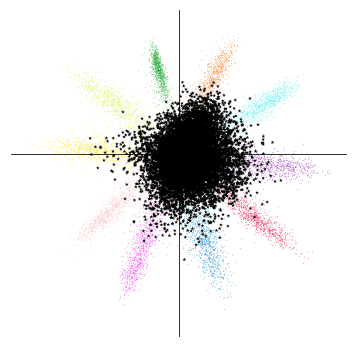

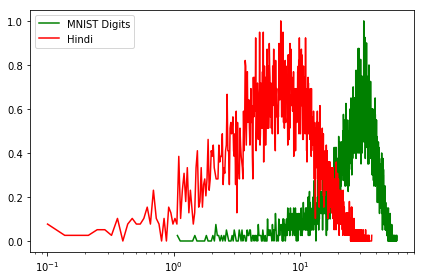

In [12]:
visualizing_tools.plotter_2D(
                    mnist_intermediate_output[0],
                    mnist.labels_test,
                    hindi_intermediate_output[0],
                    final=True,
                    file_name=results_dir+'Plots/Vanilla_{}.{}',
                    pos_labels='MNIST Digits',
                    neg_labels='Hindi'
                )

Writing results in file to create openset recognition curve

In [13]:
np.sum(mnist_intermediate_output[1],axis=1)

array([1.        , 1.0000001 , 1.        , ..., 1.        , 1.        ,
       0.99999994], dtype=float32)

In [14]:
np.sum(hindi_intermediate_output[1],axis=1)

array([0.9997468 , 0.9999904 , 0.9996419 , ..., 0.9999948 , 0.99999785,
       0.9999998 ], dtype=float32)

In [15]:
gt_y = np.concatenate((mnist.labels_test,np.ones(hindi_intermediate_output[1].shape[0])*10),axis=0)
pred_y=np.concatenate((mnist_intermediate_output[1],hindi_intermediate_output[1]),axis=0)
evaluation_tools.write_file_for_DIR(gt_y,pred_y,file_name=results_dir+'DIRs/Vanilla.txt',feature_vector=None,num_of_known_classes=10)

Plotting


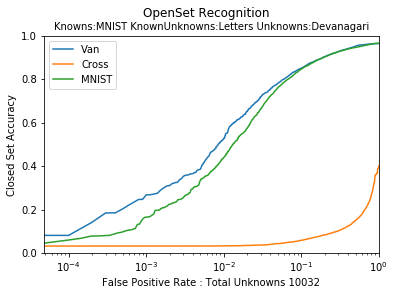

In [18]:
evaluation_tools.process_files([results_dir+'DIRs/Vanilla.txt',results_dir+'DIRs/Cross.txt','Models/DIRs/Vanilla.txt'],['Van','Cross','MNIST'])

<a id='open'></a>

Plotting


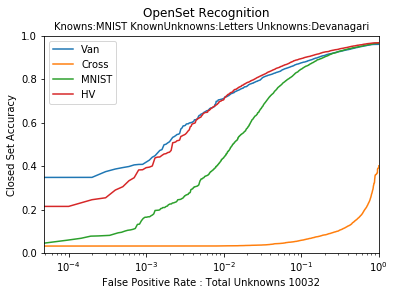

In [17]:
evaluation_tools.process_files([results_dir+'DIRs/Vanilla.txt',results_dir+'DIRs/Cross.txt','Models/DIRs/Vanilla.txt','Hindi/Vanilla.txt'],['Van','Cross','MNIST','HV'])

In [21]:
! wc -l Hindi/Vanilla.txt Alpha_Models/DIRs/Vanilla.txt

 200320 Hindi/Vanilla.txt
 200320 Alpha_Models/DIRs/Vanilla.txt
 400640 total


<a id='BG'></a>

## OpenSet Learning

<a id='Entropic'></a>

### Entropic OpenSet

In [8]:
model_saver = ModelCheckpoint(results_dir+'Cross_model.h5py', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max', period=1)
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, verbose=1, mode='max')
callbacks_list = [earlystop,model_saver]

In [9]:
negative_training_lenet_pp=model_tools.LeNet_plus_plus(activation_type=alpha_softmax)

In [10]:
X_train,Y_train,sample_weights=model_tools.concatenate_training_data(mnist,letters.X_train,0.1)

In [12]:
adam = Adam(lr=0.001)
negative_training_lenet_pp.compile(optimizer=adam,loss={'softmax': 'categorical_crossentropy'},metrics=['accuracy'])
info=negative_training_lenet_pp.fit(x=X_train,y=Y_train,validation_data=[mnist.X_val,mnist.Y_val], batch_size=128, epochs=30,verbose=1,sample_weight=sample_weights, callbacks=callbacks_list)

Train on 147840 samples, validate on 12000 samples
Epoch 1/10
147840/147840 [==============================] - 39s 266us/step - loss: 0.0069 - acc: 0.3430 - val_loss: 0.3963 - val_acc: 0.8953
Epoch 2/10
147840/147840 [==============================] - 37s 252us/step - loss: 0.0041 - acc: 0.3818 - val_loss: 0.2555 - val_acc: 0.9431
Epoch 3/10
147840/147840 [==============================] - 37s 251us/step - loss: 0.0034 - acc: 0.3857 - val_loss: 0.1954 - val_acc: 0.9574
Epoch 4/10
147840/147840 [==============================] - 37s 250us/step - loss: 0.0031 - acc: 0.3844 - val_loss: 0.1813 - val_acc: 0.9592
Epoch 5/10
147840/147840 [==============================] - 37s 248us/step - loss: 0.0028 - acc: 0.3857 - val_loss: 0.1626 - val_acc: 0.9652
Epoch 6/10
147840/147840 [==============================] - 37s 247us/step - loss: 0.0026 - acc: 0.3881 - val_loss: 0.1865 - val_acc: 0.9573
Epoch 7/10
147840/147840 [==============================] - 36s 246us/step - loss: 0.0021 - acc: 0.4403

In [13]:
negative_training_lenet_pp = keras.models.load_model(results_dir+'Cross_model.h5py')

In [14]:
mnist_intermediate_output=model_tools.extract_features(negative_training_lenet_pp,mnist.X_test)
hindi_intermediate_output=model_tools.extract_features(negative_training_lenet_pp,hindi.images)

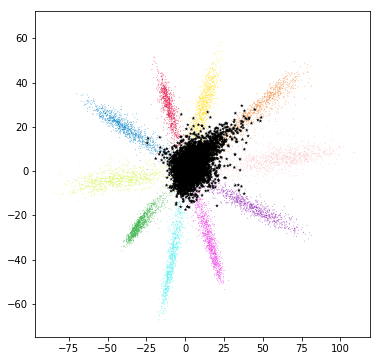

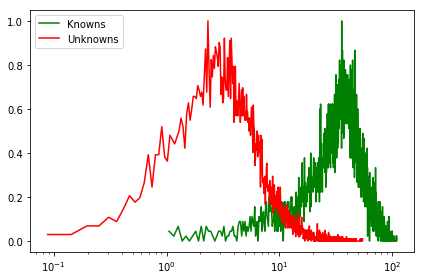

In [15]:
visualizing_tools.plotter_2D(mnist_intermediate_output[0],mnist.labels_test,hindi_intermediate_output[0])

In [17]:
gt_y = np.concatenate((mnist.labels_test,np.ones(hindi_intermediate_output[1].shape[0])*10),axis=0)
pred_y=np.concatenate((mnist_intermediate_output[1],hindi_intermediate_output[1]),axis=0)
evaluation_tools.write_file_for_DIR(gt_y,pred_y,file_name=results_dir+'DIRs/Cross.txt',feature_vector=None,num_of_known_classes=10)

In [ ]:
evaluation_tools.process_files([results_dir+'DIRs/Vanilla.txt','Models/DIRs/Vanilla.txt','Hindi/Vanilla.txt',results_dir+'DIRs/Cross.txt'],['Van','MNIST','HV','Cross'])

<a id='ObjectoSphere'></a>

### ObjectoSphere

In [6]:
def ring_loss(y_true,y_pred):
    pred=K.sqrt(K.sum(K.square(y_pred),axis=1))
    error=K.mean(K.square(
        # Loss for Knowns having magnitude greater than knownsMinimumMag
        y_true[:,0]*(K.maximum(knownsMinimumMag-pred,0.))
        # Add two losses
        +
        # Loss for unKnowns having magnitude greater than unknownsMaximumMag
        y_true[:,1]*pred
    ))
    return error

In [7]:
X_train,Y_train,sample_weights,Y_pred_with_flags=tools.concatenate_training_data(mnist,letters.X_train,0.1,ring_loss=True)

In [8]:
unknownsMaximumMag = Input((1,), dtype='float32', name='unknownsMaximumMag')
knownsMinimumMag = Input((1,), dtype='float32', name='knownsMinimumMag')
knownsMinimumMag_ = np.ones((X_train.shape[0]))*50
unknownsMaximumMag_ = np.ones((X_train.shape[0]))*0

In [9]:
Ring_Loss_Lenet_pp=tools.LeNet_plus_plus(ring_approach=True,knownsMinimumMag=knownsMinimumMag,unknownsMaximumMag=unknownsMaximumMag)

In [10]:
sgd = SGD(lr=0.01, decay=0.0009, momentum=0.8, nesterov=False)
Ring_Loss_Lenet_pp.compile(optimizer=sgd,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.00},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=3,verbose=1,sample_weight=[sample_weights,sample_weights])

Epoch 1/3
147840/147840 [==============================] - 22s 152us/step - loss: 0.0127 - pred_loss: 0.0127 - fc_loss: 5.4630 - pred_acc: 0.3703 - fc_acc: 0.3938
Epoch 2/3
147840/147840 [==============================] - 20s 137us/step - loss: 0.0113 - pred_loss: 0.0113 - fc_loss: 5.2734 - pred_acc: 0.3413 - fc_acc: 0.4245
Epoch 3/3
147840/147840 [==============================] - 20s 137us/step - loss: 0.0108 - pred_loss: 0.0108 - fc_loss: 5.2002 - pred_acc: 0.3414 - fc_acc: 0.4325


In [12]:
adam = Adam(lr=0.001)
#Ring_Loss_Lenet_pp.compile(optimizer=sgd,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.001},metrics=['accuracy'])
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.0001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=30,verbose=1,sample_weight=[sample_weights,sample_weights])

Epoch 1/30
147840/147840 [==============================] - 22s 146us/step - loss: 0.0085 - pred_loss: 0.0082 - fc_loss: 3.7689 - pred_acc: 0.3548 - fc_acc: 0.4694
Epoch 2/30
147840/147840 [==============================] - 21s 140us/step - loss: 0.0043 - pred_loss: 0.0041 - fc_loss: 1.7400 - pred_acc: 0.3877 - fc_acc: 0.4941
Epoch 3/30
147840/147840 [==============================] - 21s 141us/step - loss: 0.0034 - pred_loss: 0.0033 - fc_loss: 1.1802 - pred_acc: 0.3903 - fc_acc: 0.5045
Epoch 4/30
147840/147840 [==============================] - 21s 141us/step - loss: 0.0030 - pred_loss: 0.0029 - fc_loss: 0.9161 - pred_acc: 0.3931 - fc_acc: 0.5038
Epoch 5/30
147840/147840 [==============================] - 21s 141us/step - loss: 0.0028 - pred_loss: 0.0027 - fc_loss: 0.7791 - pred_acc: 0.3931 - fc_acc: 0.5035
Epoch 6/30
147840/147840 [==============================] - 21s 141us/step - loss: 0.0026 - pred_loss: 0.0026 - fc_loss: 0.6559 - pred_acc: 0.3901 - fc_acc: 0.5045
Epoch 7/30
14784

In [15]:
#Ring_Loss_Lenet_pp.compile(optimizer=sgd,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.0001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=30,verbose=1,sample_weight=[sample_weights,sample_weights])

Epoch 1/30
147840/147840 [==============================] - 21s 142us/step - loss: 0.0018 - pred_loss: 0.0018 - fc_loss: 0.1384 - pred_acc: 0.3979 - fc_acc: 0.5028
Epoch 2/30
147840/147840 [==============================] - 21s 141us/step - loss: 0.0017 - pred_loss: 0.0017 - fc_loss: 0.1029 - pred_acc: 0.3949 - fc_acc: 0.5032
Epoch 3/30
147840/147840 [==============================] - 21s 140us/step - loss: 0.0017 - pred_loss: 0.0017 - fc_loss: 0.1074 - pred_acc: 0.3963 - fc_acc: 0.5020
Epoch 4/30
147840/147840 [==============================] - 21s 140us/step - loss: 0.0017 - pred_loss: 0.0017 - fc_loss: 0.0888 - pred_acc: 0.3948 - fc_acc: 0.5017
Epoch 5/30
147840/147840 [==============================] - 20s 139us/step - loss: 0.0017 - pred_loss: 0.0017 - fc_loss: 0.1070 - pred_acc: 0.4032 - fc_acc: 0.5009
Epoch 6/30
147840/147840 [==============================] - 21s 141us/step - loss: 0.0017 - pred_loss: 0.0017 - fc_loss: 0.1068 - pred_acc: 0.3933 - fc_acc: 0.5032
Epoch 7/30
14784

In [16]:
#Ring_Loss_Lenet_pp.compile(optimizer=sgd,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=10,verbose=1,sample_weight=[sample_weights,sample_weights])

Epoch 1/10
147840/147840 [==============================] - 21s 142us/step - loss: 0.0016 - pred_loss: 0.0016 - fc_loss: 0.0284 - pred_acc: 0.3983 - fc_acc: 0.5024
Epoch 2/10
147840/147840 [==============================] - 21s 142us/step - loss: 0.0016 - pred_loss: 0.0016 - fc_loss: 0.0230 - pred_acc: 0.4020 - fc_acc: 0.5000
Epoch 3/10
147840/147840 [==============================] - 21s 142us/step - loss: 0.0016 - pred_loss: 0.0016 - fc_loss: 0.0202 - pred_acc: 0.3881 - fc_acc: 0.5027
Epoch 4/10
147840/147840 [==============================] - 21s 142us/step - loss: 0.0016 - pred_loss: 0.0016 - fc_loss: 0.0187 - pred_acc: 0.3879 - fc_acc: 0.4985
Epoch 5/10
147840/147840 [==============================] - 21s 143us/step - loss: 0.0016 - pred_loss: 0.0016 - fc_loss: 0.0179 - pred_acc: 0.3997 - fc_acc: 0.5016
Epoch 6/10
147840/147840 [==============================] - 21s 142us/step - loss: 0.0017 - pred_loss: 0.0017 - fc_loss: 0.0790 - pred_acc: 0.3901 - fc_acc: 0.5002
Epoch 7/10
14784

In [28]:
mnist_intermediate_output=tools.extract_features(Ring_Loss_Lenet_pp,mnist.X_test)
hindi_intermediate_output=tools.extract_features(Ring_Loss_Lenet_pp,hindi.images)

(None, 28, 28, 1) 4
(None, 28, 28, 1) 4


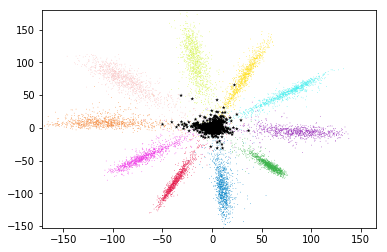

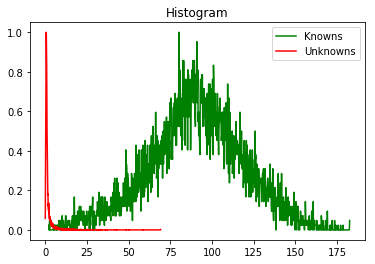

In [29]:
tools.plotter_2D(mnist_intermediate_output[0],mnist.labels_test,hindi_intermediate_output[0])

In [19]:
Ring_Loss_Lenet_pp.save('Hindi/Ring_model.h5py')

In [27]:
Ring_Loss_Lenet_pp = keras.models.load_model('Hindi/Ring_model.h5py', custom_objects={'ring_loss': ring_loss})

In [20]:
gt_y = np.concatenate((mnist.labels_test,np.ones(hindi_intermediate_output[1].shape[0])*10),axis=0)
pred_y = np.concatenate((mnist_intermediate_output[1],hindi_intermediate_output[1]),axis=0)
tools.write_file_for_DIR(gt_y,pred_y,file_name='Hindi/Ring.txt',feature_vector=None,num_of_known_classes=10)

gt_y.shape (20032,) (20032, 10)
gt_y.shape (20032,) (20032, 10)
[    0     1     2 ... 20029 20030 20031]
gt_y [ 7.  2.  1. ... 10. 10. 10.]
predicted_class_id [0 0 0 ... 9 9 9]
(200320,)
(200320,) (200320,) (200320,)
H (200320,) (200320,) (200320,) (200320,)


In [34]:
tools.write_file_for_DIR(gt_y,pred_y,file_name='Hindi/Ring.txt',feature_vector=np.concatenate((mnist_intermediate_output[0],hindi_intermediate_output[0]),axis=0),num_of_known_classes=10)

gt_y.shape (20032,) (20032, 11)
gt_y.shape (20032,) (20032, 10)
[    0     1     2 ... 20029 20030 20031]
gt_y [ 7.  2.  1. ... 10. 10. 10.]
predicted_class_id [0 0 0 ... 9 9 9]
(200320,)
file_name Hindi/Multiplying_with_mag_Ring.txt
(200320,) (200320,) (200320,)
H (200320,) (200320,) (200320,) (200320,)


In [7]:
X_train,Y_train,sample_weights,Y_pred_with_flags=tools.concatenate_training_data(mnist,letters.X_train,0.,ring_loss=True)

In [8]:
knownsMinimumMag = Input((1,), dtype='float32', name='knownsMinimumMag')
knownsMinimumMag_ = np.ones((X_train.shape[0]))*50

In [9]:
Ring_Loss_Lenet_pp=tools.LeNet_plus_plus(ring_approach=True,knownsMinimumMag=knownsMinimumMag,unknownsMaximumMag=unknownsMaximumMag)

In [10]:
sgd = SGD(lr=0.01, decay=0.0009, momentum=0.8, nesterov=False)
Ring_Loss_Lenet_pp.compile(optimizer=sgd,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.00},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=3,verbose=1,sample_weight=[sample_weights,sample_weights])

Epoch 1/3
147840/147840 [==============================] - 22s 147us/step - loss: 0.0108 - pred_loss: 0.0108 - fc_loss: 5.4625 - pred_acc: 0.2453 - fc_acc: 0.5451
Epoch 2/3
147840/147840 [==============================] - 20s 133us/step - loss: 0.0091 - pred_loss: 0.0091 - fc_loss: 5.1835 - pred_acc: 0.2707 - fc_acc: 0.5597
Epoch 3/3
147840/147840 [==============================] - 20s 133us/step - loss: 0.0086 - pred_loss: 0.0086 - fc_loss: 5.0921 - pred_acc: 0.2829 - fc_acc: 0.5602


In [11]:
adam = Adam(lr=0.001)
#Ring_Loss_Lenet_pp.compile(optimizer=sgd,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.001},metrics=['accuracy'])
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.0001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=30,verbose=1,sample_weight=[sample_weights,sample_weights])

Epoch 1/30
147840/147840 [==============================] - 22s 146us/step - loss: 0.0057 - pred_loss: 0.0053 - fc_loss: 3.4782 - pred_acc: 0.3163 - fc_acc: 0.5064
Epoch 2/30
147840/147840 [==============================] - 21s 142us/step - loss: 0.0025 - pred_loss: 0.0023 - fc_loss: 2.0747 - pred_acc: 0.3801 - fc_acc: 0.4569
Epoch 3/30
147840/147840 [==============================] - 21s 142us/step - loss: 0.0017 - pred_loss: 0.0015 - fc_loss: 1.7158 - pred_acc: 0.3964 - fc_acc: 0.4548
Epoch 4/30
147840/147840 [==============================] - 21s 143us/step - loss: 0.0013 - pred_loss: 0.0012 - fc_loss: 1.5272 - pred_acc: 0.4005 - fc_acc: 0.4596
Epoch 5/30
147840/147840 [==============================] - 21s 141us/step - loss: 0.0010 - pred_loss: 9.1083e-04 - fc_loss: 1.3587 - pred_acc: 0.4014 - fc_acc: 0.4575
Epoch 6/30
147840/147840 [==============================] - 21s 142us/step - loss: 9.8572e-04 - pred_loss: 8.5602e-04 - fc_loss: 1.2971 - pred_acc: 0.3991 - fc_acc: 0.4666
Epoc

In [12]:
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=15,verbose=1,sample_weight=[sample_weights,sample_weights])

Epoch 1/15
147840/147840 [==============================] - 21s 142us/step - loss: 1.8668e-04 - pred_loss: 1.3348e-04 - fc_loss: 0.5320 - pred_acc: 0.3933 - fc_acc: 0.4954
Epoch 2/15
147840/147840 [==============================] - 21s 141us/step - loss: 1.8400e-04 - pred_loss: 1.2991e-04 - fc_loss: 0.5409 - pred_acc: 0.3978 - fc_acc: 0.4899
Epoch 3/15
147840/147840 [==============================] - 21s 141us/step - loss: 1.8290e-04 - pred_loss: 1.2938e-04 - fc_loss: 0.5352 - pred_acc: 0.3922 - fc_acc: 0.4924
Epoch 4/15
147840/147840 [==============================] - 21s 142us/step - loss: 1.6372e-04 - pred_loss: 1.1211e-04 - fc_loss: 0.5161 - pred_acc: 0.3944 - fc_acc: 0.4953
Epoch 5/15
147840/147840 [==============================] - 21s 141us/step - loss: 1.3663e-04 - pred_loss: 8.9636e-05 - fc_loss: 0.4700 - pred_acc: 0.3955 - fc_acc: 0.4948
Epoch 6/15
147840/147840 [==============================] - 21s 142us/step - loss: 1.6165e-04 - pred_loss: 1.1236e-04 - fc_loss: 0.4929 - pr

In [13]:
mnist_intermediate_output=tools.extract_features(Ring_Loss_Lenet_pp,mnist.X_test)
hindi_intermediate_output=tools.extract_features(Ring_Loss_Lenet_pp,hindi.images)

[(None, 28, 28, 1), (None, 1), (None, 1)] 3
[(None, 28, 28, 1), (None, 1), (None, 1)] 3


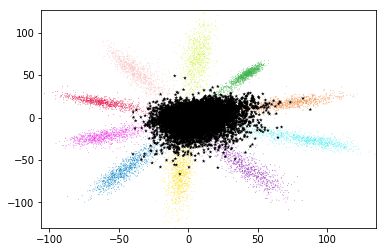

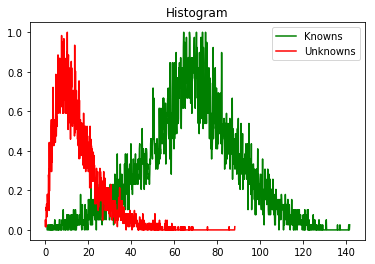

In [14]:
tools.plotter_2D(mnist_intermediate_output[0],mnist.labels_test,hindi_intermediate_output[0])

In [17]:
Ring_Loss_Lenet_pp.save('Hindi/RingWithoutCross.h5py')

In [15]:
gt_y = np.concatenate((mnist.labels_test,np.ones(hindi_intermediate_output[1].shape[0])*10),axis=0)
pred_y = np.concatenate((mnist_intermediate_output[1],hindi_intermediate_output[1]),axis=0)

In [16]:
tools.write_file_for_DIR(gt_y,pred_y,file_name='Hindi/OnlyRing.txt',feature_vector=None,num_of_known_classes=10)
tools.write_file_for_DIR(gt_y,pred_y,file_name='Hindi/OnlyRing.txt',feature_vector=np.concatenate((mnist_intermediate_output[0],hindi_intermediate_output[0]),axis=0),num_of_known_classes=10)

gt_y.shape (20032,) (20032, 10)
gt_y.shape (20032,) (20032, 10)
[    0     1     2 ... 20029 20030 20031]
gt_y [ 7.  2.  1. ... 10. 10. 10.]
predicted_class_id [0 0 0 ... 9 9 9]
(200320,)
(200320,) (200320,) (200320,)
H (200320,) (200320,) (200320,) (200320,)
gt_y.shape (20032,) (20032, 10)
gt_y.shape (20032,) (20032, 10)
[    0     1     2 ... 20029 20030 20031]
gt_y [ 7.  2.  1. ... 10. 10. 10.]
predicted_class_id [0 0 0 ... 9 9 9]
(200320,)
file_name Hindi/Multiplying_with_mag_OnlyRing.txt
(200320,) (200320,) (200320,)
H (200320,) (200320,) (200320,) (200320,)


Visualizing DIR